In [1]:
# نصب و وارد کردن کتابخانه‌های ضروری
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# تایید دسترسی به GPU
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: []


🎨 مبدل تصاویر رنگی به دیتاست GAN
🔧 مبدل دیتاست راه‌اندازی شد!
📁 پوشه ورودی: food_images
📁 پوشه خروجی: my_gan_dataset
🔍 جستجو برای تصاویر در food_images...
✅ 362 تصویر رنگی یافت شد.
🔄 پردازش 362 تصویر...


پردازش تصاویر: 100%|██████████| 362/362 [00:04<00:00, 80.81it/s]



✅ پردازش کامل شد!
📊 شکل آرایه رنگ: (362, 256, 256, 3)
📊 شکل آرایه سیاه‌سفید: (362, 256, 256, 3)
💾 داده‌ها در my_gan_dataset\numpy_data/ ذخیره شدند
🎨 ایجاد 8 نمونه تصویری...


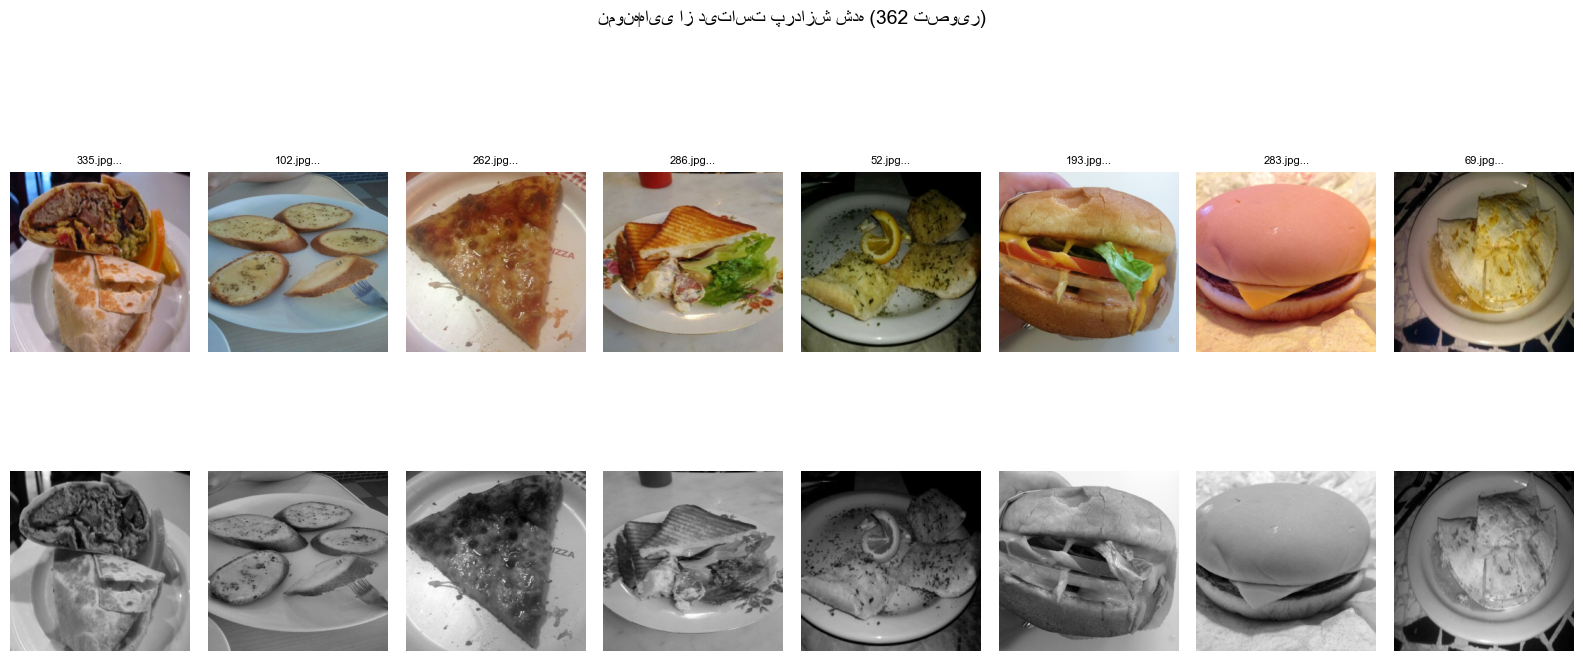

📦 tf.data.Dataset ایجاد شد:
   تعداد batchها: 12
   اندازه batch: 32

✅ دیتاست شما آماده است!
📁 همه فایل‌ها در my_gan_dataset ذخیره شدند

🎯 حالا می‌توانید مدل GAN خود را آموزش دهید:

        # نمونه کد برای آموزش
        gan = YourGANModel()
        gan.train(dataset, epochs=100)
        
        # یا از فایل‌های numpy استفاده کنید
        x_color = np.load('./my_gan_dataset/numpy_data/x_color.npy')
        x_gray = np.load('./my_gan_dataset/numpy_data/x_gray.npy')
        


In [16]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

class DatasetPreparer:
    """کلاس برای آماده‌سازی دیتاست رنگی/سیاه‌سفید برای GAN"""
    
    def __init__(self, color_images_dir, output_dir="./dataset_prepared"):
        """
        پارامترها:
            color_images_dir: مسیر پوشه حاوی تصاویر رنگی شما
            output_dir: مسیر ذخیره دیتاست پردازش شده
        """
        self.color_dir = Path(color_images_dir)
        self.output_dir = Path(output_dir)
        
        # ساختار پوشه‌های خروجی
        self.dirs = {
            'color': self.output_dir / "color",
            'gray': self.output_dir / "gray",
            'numpy': self.output_dir / "numpy_data",
            'samples': self.output_dir / "samples"
        }
        
        # ایجاد پوشه‌ها
        for dir_path in self.dirs.values():
            dir_path.mkdir(parents=True, exist_ok=True)
        
        # لیست فرمت‌های تصویری معتبر
        self.valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
        
        print(f"🔧 مبدل دیتاست راه‌اندازی شد!")
        print(f"📁 پوشه ورودی: {self.color_dir}")
        print(f"📁 پوشه خروجی: {self.output_dir}")
    
    def find_color_images(self):
        """پیدا کردن همه تصاویر رنگی در پوشه"""
        color_images = []
        
        print(f"🔍 جستجو برای تصاویر در {self.color_dir}...")
        
        # جستجوی بازگشتی در همه زیرپوشه‌ها
        for ext in self.valid_extensions:
            color_images.extend(self.color_dir.rglob(f"*{ext}"))
            color_images.extend(self.color_dir.rglob(f"*{ext.upper()}"))
        
        # حذف تکراری‌ها و مرتب‌سازی
        color_images = list(set(color_images))
        color_images.sort()
        
        print(f"✅ {len(color_images)} تصویر رنگی یافت شد.")
        return color_images
    
    def convert_to_grayscale(self, color_image_path, save_gray=True):
        """
        تبدیل یک تصویر رنگی به سیاه‌سفید
        """
        try:
            # خواندن تصویر رنگی
            color_img = cv2.imread(str(color_image_path))
            
            if color_img is None:
                print(f"⚠️ خطا در خواندن {color_image_path}")
                return None
            
            # تبدیل از BGR (OpenCV) به RGB
            color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
            
            # تبدیل به سیاه‌سفید
            gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
            gray_img_3channel = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
            
            # ذخیره تصاویر
            if save_gray:
                base_name = color_image_path.stem
                relative_path = color_image_path.relative_to(self.color_dir).parent
                
                # ذخیره تصویر رنگی
                color_output_dir = self.dirs['color'] / relative_path
                color_output_dir.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str(color_output_dir / f"{base_name}_color.jpg"), 
                           cv2.cvtColor(color_img_rgb, cv2.COLOR_RGB2BGR))
                
                # ذخیره تصویر سیاه‌سفید
                gray_output_dir = self.dirs['gray'] / relative_path
                gray_output_dir.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str(gray_output_dir / f"{base_name}_gray.jpg"), 
                           cv2.cvtColor(gray_img_3channel, cv2.COLOR_RGB2BGR))
            
            return color_img_rgb, gray_img_3channel
            
        except Exception as e:
            print(f"❌ خطا در پردازش {color_image_path}: {e}")
            return None
    
    def resize_images(self, color_img, gray_img, target_size=(256, 256)):
        """تغییر اندازه تصاویر به اندازه هدف"""
        color_resized = cv2.resize(color_img, target_size)
        gray_resized = cv2.resize(gray_img, target_size)
        return color_resized, gray_resized
    
    def normalize_images(self, color_img, gray_img):
        """نرمال‌سازی تصاویر به بازه [-1, 1] برای GAN"""
        color_norm = (color_img.astype(np.float32) / 127.5) - 1
        gray_norm = (gray_img.astype(np.float32) / 127.5) - 1
        return color_norm, gray_norm
    
    def prepare_all_images(self, target_size=(256, 256), max_images=None, show_progress=True):
        """
        پردازش همه تصاویر و ایجاد دیتاست نهایی
        """
        # پیدا کردن همه تصاویر
        color_images_paths = self.find_color_images()
        
        if max_images:
            color_images_paths = color_images_paths[:max_images]
        
        print(f"🔄 پردازش {len(color_images_paths)} تصویر...")
        
        # لیست‌های نگهداری تصاویر پردازش شده
        color_processed = []
        gray_processed = []
        valid_paths = []
        
        # نوار پیشرفت
        if show_progress:
            try:
                from tqdm import tqdm
                iterator = tqdm(color_images_paths, desc="پردازش تصاویر")
            except ImportError:
                iterator = color_images_paths
                print("📦 کتابخانه tqdm نصب نیست. برای نصب: pip install tqdm")
        else:
            iterator = color_images_paths
        
        # پردازش هر تصویر
        for img_path in iterator:
            result = self.convert_to_grayscale(img_path, save_gray=True)
            
            if result is not None:
                color_img, gray_img = result
                
                # تغییر اندازه
                color_resized, gray_resized = self.resize_images(color_img, gray_img, target_size)
                
                # نرمال‌سازی
                color_norm, gray_norm = self.normalize_images(color_resized, gray_resized)
                
                # اضافه کردن به لیست‌ها
                color_processed.append(color_norm)
                gray_processed.append(gray_norm)
                valid_paths.append(img_path)
        
        # تبدیل به numpy arrays
        if color_processed:
            color_array = np.array(color_processed)
            gray_array = np.array(gray_processed)
            
            print(f"\n✅ پردازش کامل شد!")
            print(f"📊 شکل آرایه رنگ: {color_array.shape}")
            print(f"📊 شکل آرایه سیاه‌سفید: {gray_array.shape}")
            
            # ذخیره به صورت فایل numpy
            self.save_as_numpy(color_array, gray_array)
            
            # ایجاد نمونه‌های تصویری
            self.create_sample_images(color_array, gray_array, valid_paths)
            
            return color_array, gray_array
        else:
            print("❌ هیچ تصویری پردازش نشد!")
            return None, None
    
    def save_as_numpy(self, color_array, gray_array):
        """ذخیره داده‌ها به صورت فایل‌های numpy"""
        np.save(self.dirs['numpy'] / "x_color.npy", color_array)
        np.save(self.dirs['numpy'] / "x_gray.npy", gray_array)
        print(f"💾 داده‌ها در {self.dirs['numpy']}/ ذخیره شدند")
    
    def create_sample_images(self, color_array, gray_array, paths, num_samples=8):
        """ایجاد نمونه‌های تصویری برای بررسی کیفیت"""
        print(f"🎨 ایجاد {num_samples} نمونه تصویری...")
        
        plt.figure(figsize=(16, 8))
        
        # انتخاب تصاویر نمونه به صورت تصادفی
        indices = np.random.choice(len(color_array), min(num_samples, len(color_array)), replace=False)
        
        for i, idx in enumerate(indices):
            # بازگردانی مقادیر نرمال‌شده به [0, 255]
            color_sample = ((color_array[idx] + 1) * 127.5).astype(np.uint8)
            gray_sample = ((gray_array[idx] + 1) * 127.5).astype(np.uint8)
            
            # نام فایل
            filename = Path(paths[idx]).name
            
            # نمایش تصویر رنگی
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(color_sample)
            plt.title(f"{filename[:15]}...", fontsize=8)
            plt.axis('off')
            
            # نمایش تصویر سیاه‌سفید
            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(gray_sample[:, :, 0], cmap='gray')
            plt.axis('off')
        
        plt.suptitle(f"نمونه‌هایی از دیتاست پردازش شده ({len(color_array)} تصویر)", fontsize=14)
        plt.tight_layout()
        plt.savefig(self.dirs['samples'] / "dataset_samples.png", dpi=150)
        plt.show()
    
    def create_tf_dataset(self, color_array, gray_array, batch_size=32, shuffle=True):
        """ایجاد tf.data.Dataset برای آموزش"""
        import tensorflow as tf
        
        dataset = tf.data.Dataset.from_tensor_slices((gray_array, color_array))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(color_array))
        
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        print(f"📦 tf.data.Dataset ایجاد شد:")
        print(f"   تعداد batchها: {len(list(dataset))}")
        print(f"   اندازه batch: {batch_size}")
        
        return dataset

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ████████████████████████████████████████████████████ اجرای اصلی ███████████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

if __name__ == "__main__":
    print("=" * 60)
    print("🎨 مبدل تصاویر رنگی به دیتاست GAN")
    print("=" * 60)
    
    # ★★★★★ این قسمت را تنظیم کنید ★★★★★
    # مسیر پوشه تصاویر رنگی خود را اینجا قرار دهید
    YOUR_COLOR_IMAGES_FOLDER = "food_images"  # ← این خط را تغییر دهید
    
    # ایجاد نمونه کلاس
    preparer = DatasetPreparer(
        color_images_dir=YOUR_COLOR_IMAGES_FOLDER,
        output_dir="./my_gan_dataset"
    )
    
    # پردازش همه تصاویر
    color_array, gray_array = preparer.prepare_all_images(
        target_size=(256, 256),
        max_images=None,
        show_progress=True
    )
    
    if color_array is not None:
        # ایجاد دیتاست TensorFlow
        dataset = preparer.create_tf_dataset(color_array, gray_array, batch_size=32)
        
        # ذخیره اطلاعات دیتاست
        info_file = preparer.output_dir / "dataset_info.txt"
        with open(info_file, 'w', encoding='utf-8') as f:
            f.write("دیتاست GAN برای رنگی‌سازی\n")
            f.write(f"تاریخ ایجاد: {np.datetime64('now')}\n")
            f.write("\n")
            f.write("📊 آمار:\n")
            f.write(f"تعداد تصاویر: {len(color_array)}\n")
            f.write(f"اندازه هر تصویر: {color_array.shape[1:]} (HxWxC)\n")
            f.write("\n")
            f.write("📁 ساختار پوشه:\n")
            f.write(f"{preparer.output_dir}/\n")
            f.write("  ├── color/       # تصاویر رنگی اصلی\n")
            f.write("  ├── gray/        # تصاویر سیاه‌سفید\n")
            f.write("  ├── numpy_data/  # فایل‌های .npy برای آموزش\n")
            f.write("  └── samples/     # تصاویر نمونه\n")
        
        print(f"\n" + "=" * 60)
        print("✅ دیتاست شما آماده است!")
        print(f"📁 همه فایل‌ها در {preparer.output_dir} ذخیره شدند")
        print("=" * 60)
        print("\n🎯 حالا می‌توانید مدل GAN خود را آموزش دهید:")
        print("""
        # نمونه کد برای آموزش
        gan = YourGANModel()
        gan.train(dataset, epochs=100)
        
        # یا از فایل‌های numpy استفاده کنید
        x_color = np.load('./my_gan_dataset/numpy_data/x_color.npy')
        x_gray = np.load('./my_gan_dataset/numpy_data/x_gray.npy')
        """)

🎬 Starting Image Colorization Project with GAN
📊 Initial data shape:
  x_color: (362, 256, 256, 3)
  x_gray: (362, 256, 256, 3)

⚠️ Grayscale images have 3 channels! Converting to 1 channel...
✅ Grayscale images fixed:
  New shape: (362, 256, 256, 1)

📊 Final data shape:
  Color images (target): (362, 256, 256, 3)
  Grayscale images (input): (362, 256, 256, 1)

🎨 Displaying fixed samples:



⚙️ Initial setup...
📐 Dataset specifications:
  Image height: 256
  Image width: 256
  Grayscale channels: 1
  Color channels: 3

🏗️ Building Generator with input (256, 256, 1)...
✅ Generator built!

🏗️ Building Discriminator...
✅ Discriminator built!

📊 Generator summary:
  Input: (None, 256, 256, 1)
  Output: (None, 256, 256, 3)

📊 Discriminator summary:
  Input 1 (grayscale): (None, 256, 256, 1)
  Input 2 (color): (None, 256, 256, 3)

⚡ Training with settings:
  Epochs: 10
  Batch Size: 4
  Image Size: 256x256

🚀 Starting GAN model training (simple version)
📈 Number of epochs: 10
📦 Batch size: 4
🖼️ Number of images: 362
📍 Epoch 1/10 | Time: 163.6s
   📉 D Loss: 14.7882 | 📈 G Loss: 29.8585
📍 Epoch 5/10 | Time: 94.7s
   📉 D Loss: 14.7115 | 📈 G Loss: 25.9517
📍 Epoch 10/10 | Time: 97.1s
   📉 D Loss: 15.6743 | 📈 G Loss: 23.0234



💾 Saving final model...


✅ Training completed!

📁 Created files:
   - colorization_generator_simple.h5 (main model)
   - training_progress_simple.png (progress chart)
   - sample_epoch_*.png (epoch samples)

🎉 Now you can use the model for colorizing new images!

🧪 Testing trained model on new samples...


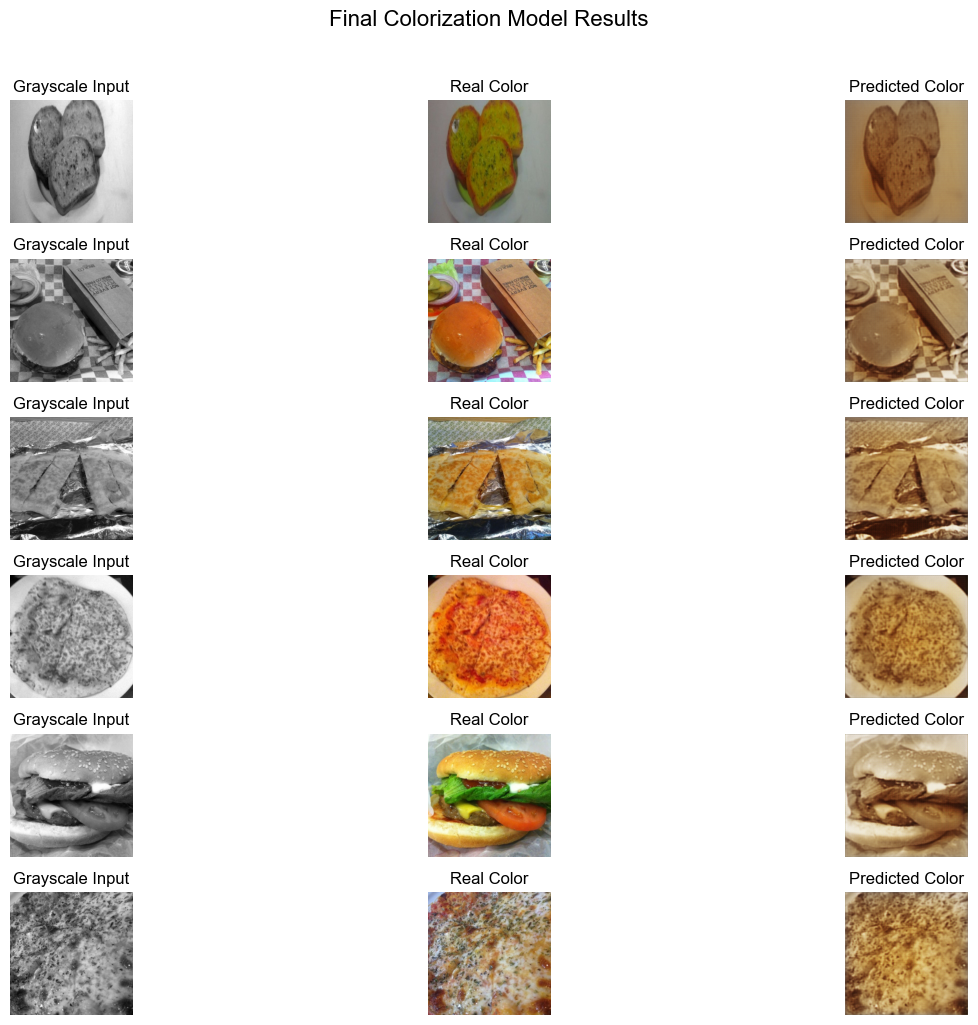

✅ Testing completed! Model is ready to use.


In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# تنظیم فونت انگلیسی استاندارد
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

print("=" * 70)
print("🎬 Starting Image Colorization Project with GAN")
print("=" * 70)

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ████████████████████████████████████████████ 1. Load and Fix Dataset ██████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

# Load dataset
x_color = np.load('./my_gan_dataset/numpy_data/x_color.npy')
x_gray = np.load('./my_gan_dataset/numpy_data/x_gray.npy')

print(f"📊 Initial data shape:")
print(f"  x_color: {x_color.shape}")  # Should be (n, h, w, 3)
print(f"  x_gray: {x_gray.shape}")    # Problem: probably (n, h, w, 3)

# Check and fix grayscale images
if x_gray.shape[-1] == 3:
    print("\n⚠️ Grayscale images have 3 channels! Converting to 1 channel...")
    
    # Method 1: Average channels (RGB to Grayscale)
    x_gray_fixed = np.mean(x_gray, axis=-1, keepdims=True)
    
    print(f"✅ Grayscale images fixed:")
    print(f"  New shape: {x_gray_fixed.shape}")
    
    # Replace with fixed data
    x_gray = x_gray_fixed
else:
    print("✅ Grayscale images already have 1 channel.")

# Final check
print(f"\n📊 Final data shape:")
print(f"  Color images (target): {x_color.shape}")
print(f"  Grayscale images (input): {x_gray.shape}")

# Display samples for verification
print("\n🎨 Displaying fixed samples:")
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow((x_gray[i] + 1) / 2, cmap='gray')
    plt.title(f"Grayscale Input {i+1}")
    plt.axis('off')
    
    plt.subplot(2, 3, i + 4)
    plt.imshow((x_color[i] + 1) / 2)
    plt.title(f"Color Target {i+1}")
    plt.axis('off')
plt.suptitle("Fixed Dataset", fontsize=14)
plt.tight_layout()
plt.show()

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# █████████████████████████████████████████ 2. Build Generator (Modified) ████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

def build_generator(input_shape=(256, 256, 1)):
    """Build U-Net generator for 1-channel input"""
    
    print(f"\n🏗️ Building Generator with input {input_shape}...")
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # ========== ENCODER ==========
    # Block 1: 256 → 128
    e1 = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    e1 = tf.keras.layers.LeakyReLU(alpha=0.2)(e1)
    
    # Block 2: 128 → 64
    e2 = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(e1)
    e2 = tf.keras.layers.BatchNormalization()(e2)
    e2 = tf.keras.layers.LeakyReLU(alpha=0.2)(e2)
    
    # Block 3: 64 → 32
    e3 = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(e2)
    e3 = tf.keras.layers.BatchNormalization()(e3)
    e3 = tf.keras.layers.LeakyReLU(alpha=0.2)(e3)
    
    # ========== BOTTLENECK ==========
    # Block 4: 32 → 16
    e4 = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(e3)
    e4 = tf.keras.layers.BatchNormalization()(e4)
    e4 = tf.keras.layers.LeakyReLU(alpha=0.2)(e4)
    
    # Block 5: 16 → 8
    e5 = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(e4)
    e5 = tf.keras.layers.BatchNormalization()(e5)
    e5 = tf.keras.layers.LeakyReLU(alpha=0.2)(e5)
    
    # Block 6: 8 → 4
    bottleneck = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(e5)
    bottleneck = tf.keras.layers.BatchNormalization()(bottleneck)
    bottleneck = tf.keras.layers.LeakyReLU(alpha=0.2)(bottleneck)
    
    # ========== DECODER ==========
    # Block 1: 4 → 8
    d1 = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same')(bottleneck)
    d1 = tf.keras.layers.BatchNormalization()(d1)
    d1 = tf.keras.layers.Dropout(0.5)(d1)
    d1 = tf.keras.layers.Concatenate()([d1, e5])
    d1 = tf.keras.layers.ReLU()(d1)
    
    # Block 2: 8 → 16
    d2 = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same')(d1)
    d2 = tf.keras.layers.BatchNormalization()(d2)
    d2 = tf.keras.layers.Dropout(0.5)(d2)
    d2 = tf.keras.layers.Concatenate()([d2, e4])
    d2 = tf.keras.layers.ReLU()(d2)
    
    # Block 3: 16 → 32
    d3 = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same')(d2)
    d3 = tf.keras.layers.BatchNormalization()(d3)
    d3 = tf.keras.layers.Concatenate()([d3, e3])
    d3 = tf.keras.layers.ReLU()(d3)
    
    # Block 4: 32 → 64
    d4 = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(d3)
    d4 = tf.keras.layers.BatchNormalization()(d4)
    d4 = tf.keras.layers.Concatenate()([d4, e2])
    d4 = tf.keras.layers.ReLU()(d4)
    
    # Block 5: 64 → 128
    d5 = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d4)
    d5 = tf.keras.layers.BatchNormalization()(d5)
    d5 = tf.keras.layers.Concatenate()([d5, e1])
    d5 = tf.keras.layers.ReLU()(d5)
    
    # ========== OUTPUT LAYER ==========
    # Output 3 channels (RGB)
    output = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                            activation='tanh', name='output')(d5)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='Colorization_Generator')
    
    print("✅ Generator built!")
    return model

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# █████████████████████████████████████████ 3. Build Discriminator ███████████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

def build_discriminator(input_shape_gray=(256, 256, 1), input_shape_color=(256, 256, 3)):
    """Build PatchGAN Discriminator"""
    
    print(f"\n🏗️ 
           Building Discriminator...")
    
    input_gray = tf.keras.layers.Input(shape=input_shape_gray, name='input_gray')
    input_color = tf.keras.layers.Input(shape=input_shape_color, name='input_color')
    
    combined = tf.keras.layers.Concatenate(axis=-1)([input_gray, input_color])
    
    # Simpler architecture for faster training
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(combined)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    # PatchGAN output
    output = tf.keras.layers.Conv2D(1, 4, padding='same', name='output')(x)
    
    model = tf.keras.Model(inputs=[input_gray, input_color], outputs=output, name='PatchGAN_Discriminator')
    
    print("✅ Discriminator built!")
    return model

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ███████████████████████████████████████████ 4. Initial Setup ███████████████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

print("\n⚙️ Initial setup...")

# Check image dimensions
IMG_HEIGHT = x_gray.shape[1]
IMG_WIDTH = x_gray.shape[2]
GRAY_CHANNELS = x_gray.shape[3]  # Should be 1
COLOR_CHANNELS = x_color.shape[3]  # Should be 3

print(f"📐 Dataset specifications:")
print(f"  Image height: {IMG_HEIGHT}")
print(f"  Image width: {IMG_WIDTH}")
print(f"  Grayscale channels: {GRAY_CHANNELS}")
print(f"  Color channels: {COLOR_CHANNELS}")

# Build models with correct dimensions
generator = build_generator(input_shape=(IMG_HEIGHT, IMG_WIDTH, GRAY_CHANNELS))
discriminator = build_discriminator(
    input_shape_gray=(IMG_HEIGHT, IMG_WIDTH, GRAY_CHANNELS),
    input_shape_color=(IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)
)

# Display summary
print("\n📊 Generator summary:")
print(f"  Input: {generator.input_shape}")
print(f"  Output: {generator.output_shape}")

print("\n📊 Discriminator summary:")
print(f"  Input 1 (grayscale): {discriminator.input[0].shape}")
print(f"  Input 2 (color): {discriminator.input[1].shape}")

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ███████████████████████████████████████████ 5. Loss Functions & Optimizers █████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, generated_images, target_images):
    adversarial_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target_images - generated_images))
    LAMBDA = 100
    total_loss = adversarial_loss + (LAMBDA * l1_loss)
    return total_loss, adversarial_loss, l1_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ███████████████████████████████████████████ 6. Training Function (Simplified) █████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

@tf.function
def train_step(gray_images, color_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate color images
        generated_images = generator(gray_images, training=True)
        
        # Evaluate Discriminator
        real_output = discriminator([gray_images, color_images], training=True)
        fake_output = discriminator([gray_images, generated_images], training=True)
        
        # Calculate losses
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_total_loss, gen_adv_loss, gen_l1_loss = generator_loss(
            fake_output, generated_images, color_images)
    
    # Calculate and apply gradients
    gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    return disc_loss, gen_total_loss, gen_adv_loss, gen_l1_loss

def train_model_simple(gray_data, color_data, epochs=50, batch_size=8):
    """Simplified training function"""
    
    print(f"\n🚀 Starting GAN model training (simple version)")
    print(f"📈 Number of epochs: {epochs}")
    print(f"📦 Batch size: {batch_size}")
    print(f"🖼️ Number of images: {len(gray_data)}")
    print("=" * 70)
    
    # Create Dataset
    dataset = tf.data.Dataset.from_tensor_slices((gray_data, color_data))
    dataset = dataset.shuffle(buffer_size=len(gray_data))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # History
    history = {
        'disc_loss': [],
        'gen_loss': [],
        'gen_adv_loss': [],
        'gen_l1_loss': []
    }
    
    # Training
    for epoch in range(epochs):
        start_time = time.time()
        
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        num_batches = 0
        
        for gray_batch, color_batch in dataset:
            disc_loss, gen_loss, _, _ = train_step(gray_batch, color_batch)
            epoch_disc_loss += disc_loss
            epoch_gen_loss += gen_loss
            num_batches += 1
        
        # Average losses
        avg_disc_loss = epoch_disc_loss / num_batches
        avg_gen_loss = epoch_gen_loss / num_batches
        
        history['disc_loss'].append(float(avg_disc_loss))
        history['gen_loss'].append(float(avg_gen_loss))
        
        # Display progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            elapsed_time = time.time() - start_time
            print(f"📍 Epoch {epoch + 1}/{epochs} | Time: {elapsed_time:.1f}s")
            print(f"   📉 D Loss: {avg_disc_loss:.4f} | 📈 G Loss: {avg_gen_loss:.4f}")
            
            # Display sample
            if (epoch + 1) % 10 == 0:
                test_samples = gray_data[:3]
                predictions = generator.predict(test_samples, verbose=0)
                
                plt.figure(figsize=(12, 6))
                for i in range(3):
                    plt.subplot(2, 3, i + 1)
                    plt.imshow((test_samples[i] + 1) / 2, cmap='gray')
                    plt.title("Input")
                    plt.axis('off')
                    
                    plt.subplot(2, 3, i + 4)
                    plt.imshow((predictions[i] + 1) / 2)
                    plt.title("Output")
                    plt.axis('off')
                
                plt.suptitle(f'Epoch {epoch + 1}', fontsize=14)
                plt.tight_layout()
                plt.savefig(f'sample_epoch_{epoch+1}.png')
                plt.show()
    
    return history

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ███████████████████████████████████████████ 7. Run Training ████████████████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

# Training parameters
EPOCHS = 10  # Start with a small number
BATCH_SIZE = 4  # Use 4 or 2 if memory is limited

print("\n" + "=" * 70)
print("⚡ Training with settings:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print("=" * 70)

# Start training
history = train_model_simple(
    gray_data=x_gray,
    color_data=x_color,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ███████████████████████████████████████████ 8. Save Model & Results ████████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

print("\n💾 Saving final model...")

# Save model
generator.save('colorization_generator_simple.h5')

# Plot progress
plt.figure(figsize=(10, 5))
plt.plot(history['disc_loss'], label='Discriminator Loss', color='red')
plt.plot(history['gen_loss'], label='Generator Loss', color='blue')
plt.title('GAN Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_progress_simple.png', dpi=150)
plt.show()

print("✅ Training completed!")
print("\n📁 Created files:")
print("   - colorization_generator_simple.h5 (main model)")
print("   - training_progress_simple.png (progress chart)")
print("   - sample_epoch_*.png (epoch samples)")

print("\n" + "=" * 70)
print("🎉 Now you can use the model for colorizing new images!")
print("=" * 70)

# ████████████████████████████████████████████████████████████████████████████████████████████████████████
# ███████████████████████████████████████████ 9. Test Final Model ████████████████████████████████████████
# ████████████████████████████████████████████████████████████████████████████████████████████████████████

print("\n🧪 Testing trained model on new samples...")

# Select 6 random samples
indices = np.random.choice(len(x_gray), 6, replace=False)
test_gray = x_gray[indices]
test_color = x_color[indices]

# Predict
predictions = generator.predict(test_gray, verbose=0)

# Display results
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(6, 3, i*3 + 1)
    plt.imshow((test_gray[i] + 1) / 2, cmap='gray')
    plt.title("Grayscale Input")
    plt.axis('off')
    
    plt.subplot(6, 3, i*3 + 2)
    plt.imshow((test_color[i] + 1) / 2)
    plt.title("Real Color")
    plt.axis('off')
    
    plt.subplot(6, 3, i*3 + 3)
    plt.imshow((predictions[i] + 1) / 2)
    plt.title("Predicted Color")
    plt.axis('off')

plt.suptitle('Final Colorization Model Results', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('final_test_results.png', dpi=150)
plt.show()

print("✅ Testing completed! Model is ready to use.")

🎨 SIMPLE BUT EFFECTIVE COLORIZATION MODEL
📥 Loading data...
📊 Data shapes: Gray=(362, 256, 256, 3), Color=(362, 256, 256, 3)
Converting RGB to grayscale...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0039215684..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038908124..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038293004..0.0039215684].


🖼️ Image size: 256x256


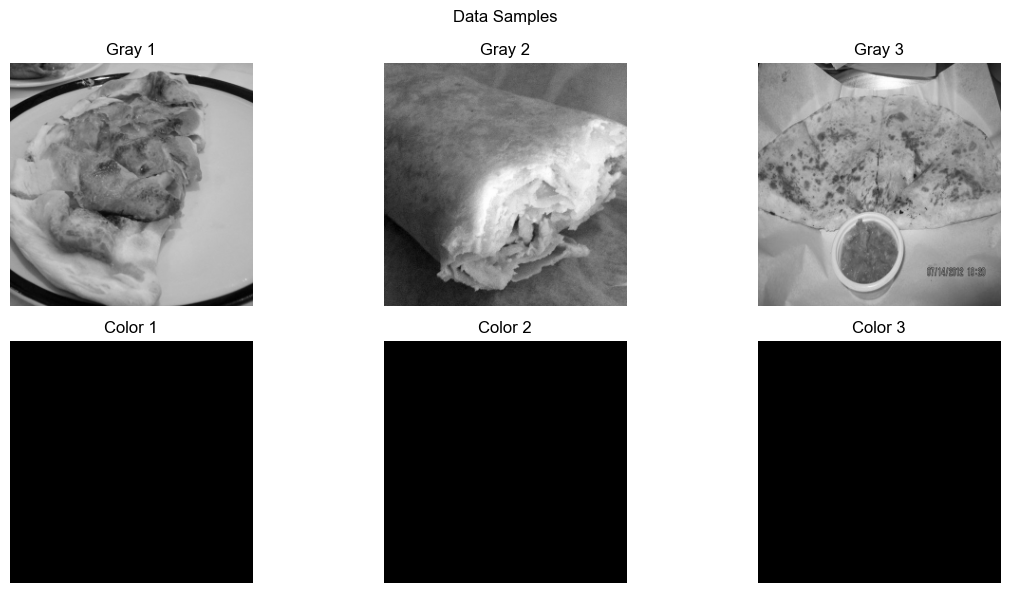


⚙️ BUILDING MODELS

🏗️ Building Simple Color Generator...
✅ Generator built: 113,333 parameters
   Test output range: [-0.311, 0.239]

🏗️ Building Color-Aware Discriminator...

✅ Discriminator built: 17,438,865 parameters

📉 Setting up color-focused loss functions...

⚡ Setting up optimizers...

📈 Using 30 samples for training

STEP 1: PRE-TRAINING

🎨 PRE-TRAINING GENERATOR (COLOR ONLY)

🔨 Pre-train Epoch 1/3
  Loss: 1.4799
  Output range: [-0.064, 0.004]

🔨 Pre-train Epoch 2/3
  Loss: 0.9683
  Output range: [-0.149, 0.055]

🔨 Pre-train Epoch 3/3
  Loss: 0.7721
  Output range: [-0.313, 0.116]

✅ Pre-training complete!

STEP 2: FULL GAN TRAINING

🎨 STARTING COLORIZATION TRAINING
📊 Samples: 30
📈 Epochs: 10
📦 Batch size: 4

📅 EPOCH 1/10
--------------------------------------------------
  Batch 1: D=1.663, G=37.130, L1=0.364
  Batch 3: D=0.098, G=49.716, L1=0.345
  Batch 5: D=0.000, G=91.241, L1=0.307
  Batch 7: D=0.000, G=79.442, L1=0.277

📊 Epoch 1 Summary (16.6s):
   📉 Disc Loss: 0.22

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0039215684..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038908124..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038293004..0.0039215684].


  💾 Saved to: progress/epoch_001.png


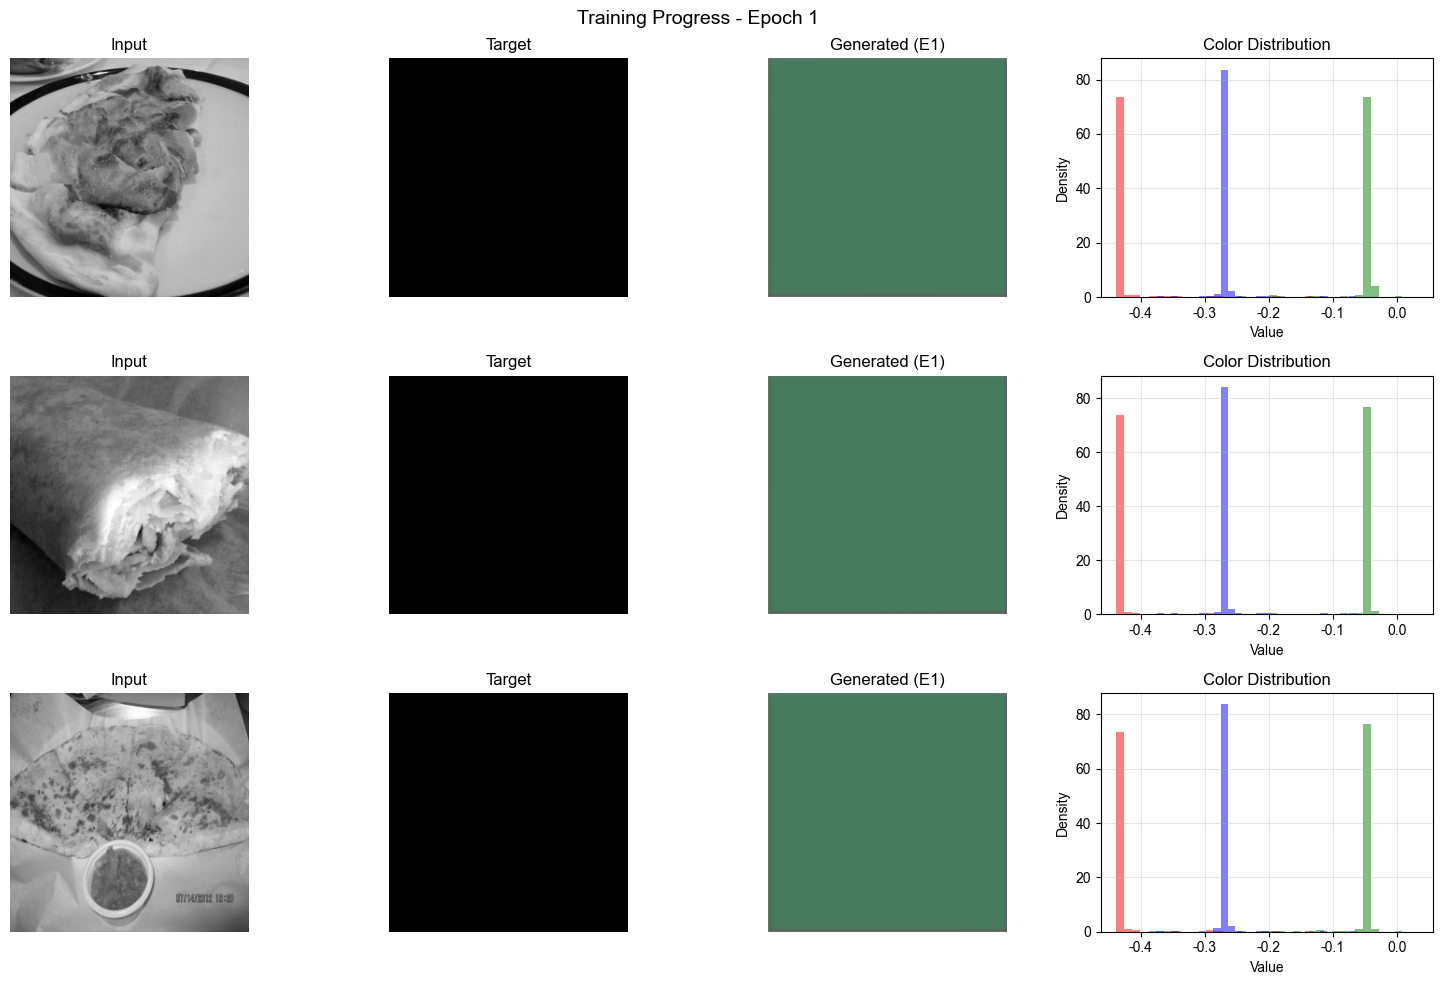

  Generated stats:
    Range: [-0.439, 0.033]
    Mean RGB: [-0.433, -0.047, -0.266]

📅 EPOCH 2/10
--------------------------------------------------
  Batch 1: D=0.000, G=81.953, L1=0.260
  Batch 3: D=0.000, G=81.300, L1=0.253
  Batch 5: D=0.000, G=80.068, L1=0.248
  Batch 7: D=0.000, G=71.775, L1=0.241

📊 Epoch 2 Summary (13.7s):
   📉 Disc Loss: 0.0004
   📈 Gen Loss: 77.8104
   🎨 L1 Loss: 0.2489
   🌈 Color Diversity: 0.0075
   💎 Saturation: 0.0468

👁️ Showing progress for epoch 2...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0039215684..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038908124..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038293004..0.0039215684].


  💾 Saved to: progress/epoch_002.png


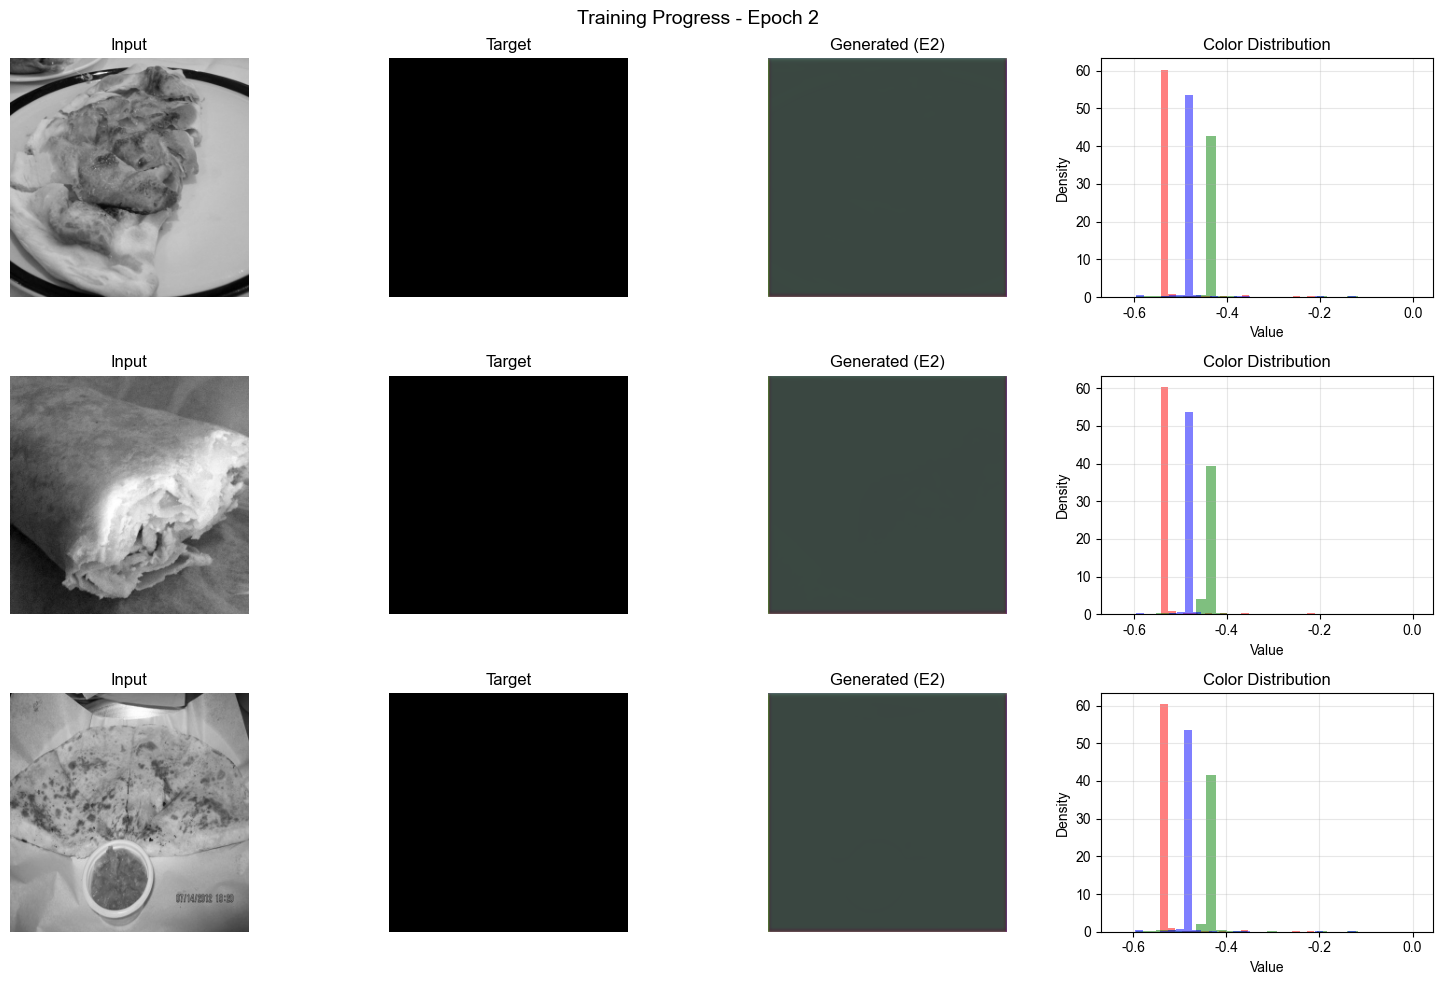

  Generated stats:
    Range: [-0.640, 0.012]
    Mean RGB: [-0.535, -0.439, -0.483]

📅 EPOCH 3/10
--------------------------------------------------
  Batch 1: D=6.026, G=102.046, L1=0.235
  Batch 3: D=7.471, G=135.863, L1=0.228
  Batch 5: D=0.000, G=112.172, L1=0.225
  Batch 7: D=0.000, G=136.958, L1=0.221

📊 Epoch 3 Summary (13.9s):
   📉 Disc Loss: 15.2471
   📈 Gen Loss: 134.6387
   🎨 L1 Loss: 0.2260
   🌈 Color Diversity: 0.0027
   💎 Saturation: 0.0131

📅 EPOCH 4/10
--------------------------------------------------
  Batch 1: D=0.000, G=185.773, L1=0.216
  Batch 3: D=0.000, G=186.150, L1=0.211
  Batch 5: D=0.000, G=185.405, L1=0.208
  Batch 7: D=0.000, G=184.971, L1=0.204

📊 Epoch 4 Summary (13.8s):
   📉 Disc Loss: 0.0000
   📈 Gen Loss: 185.3427
   🎨 L1 Loss: 0.2091
   🌈 Color Diversity: 0.0027
   💎 Saturation: 0.0122

👁️ Showing progress for epoch 4...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0039215684..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038908124..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038293004..0.0039215684].


  💾 Saved to: progress/epoch_004.png


  Generated stats:
    Range: [-0.875, -0.045]
    Mean RGB: [-0.631, -0.840, -0.739]

📅 EPOCH 5/10
--------------------------------------------------
  Batch 1: D=0.000, G=223.604, L1=0.199
  Batch 3: D=0.000, G=222.370, L1=0.197
  Batch 5: D=0.000, G=221.206, L1=0.192
  Batch 7: D=0.000, G=220.022, L1=0.188

📊 Epoch 5 Summary (14.0s):
   📉 Disc Loss: 0.0000
   📈 Gen Loss: 221.4362
   🎨 L1 Loss: 0.1935
   🌈 Color Diversity: 0.0026
   💎 Saturation: 0.0125
  ✅ Good L1 loss achieved!

✅ TRAINING COMPLETED SUCCESSFULLY!

🧪 FINAL TESTING


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0039215684..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038908124..0.0039215684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038293004..0.0039215684].



📊 Final Statistics:
  Output Range: [-0.908, -0.040]
  Mean RGB: [-0.660, -0.889, -0.790]
  Std RGB: [0.030, 0.038, 0.037]
  L1 Loss: 0.2210

🎨 Displaying final results...
💾 Saved: final_results.png


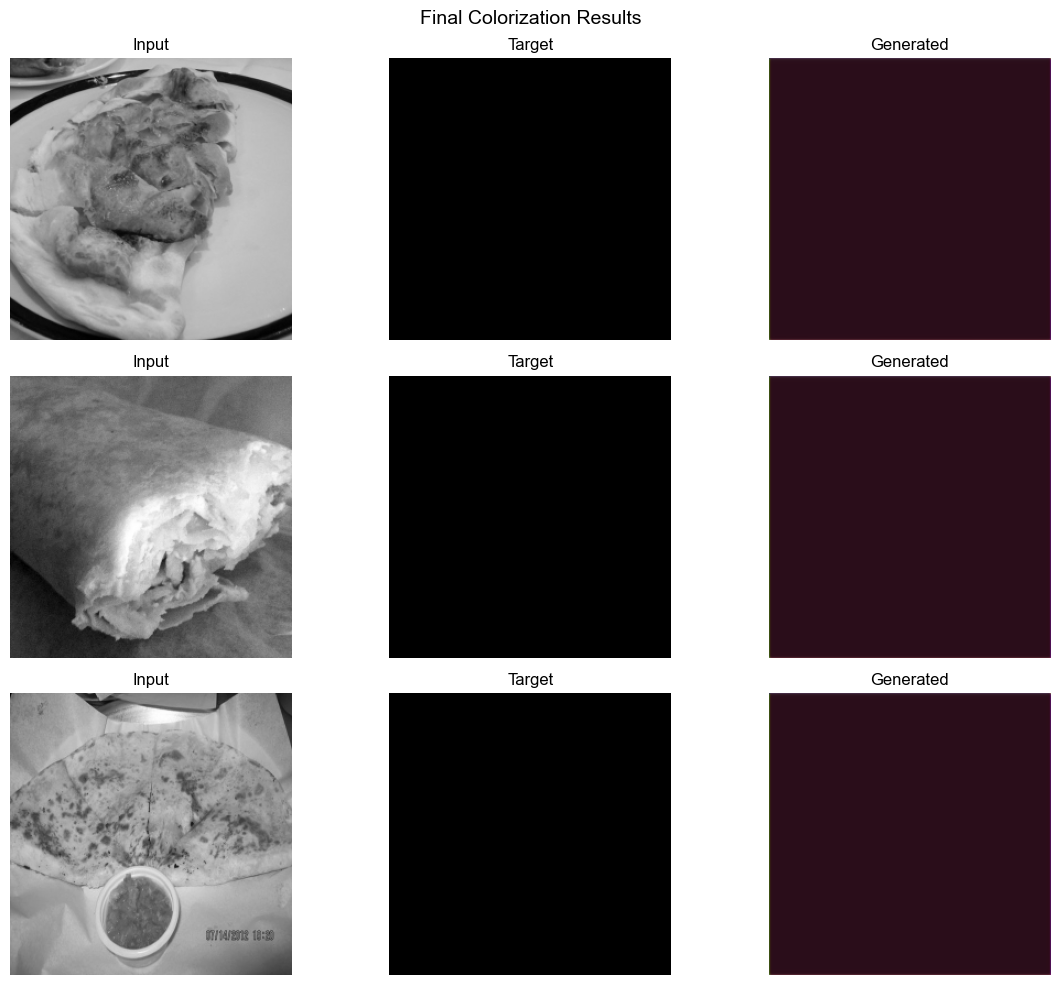


📈 Plotting training history...
💾 Saved: training_history.png



💾 Saving model...
✅ Model saved: simple_colorization_generator.h5

🎉 COLORIZATION MODEL TRAINING COMPLETE!


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

print("=" * 70)
print("🎨 SIMPLE BUT EFFECTIVE COLORIZATION MODEL")
print("=" * 70)

# █████████████████████████████████████████████████████████████████████████████████
# 1. LOAD AND PREPARE DATA
# █████████████████████████████████████████████████████████████████████████████████

print("📥 Loading data...")

# Load data
x_color = np.load('./my_gan_dataset/numpy_data/x_color.npy')
x_gray = np.load('./my_gan_dataset/numpy_data/x_gray.npy')

print(f"📊 Data shapes: Gray={x_gray.shape}, Color={x_color.shape}")

# Convert grayscale if needed
if x_gray.shape[-1] == 3:
    print("Converting RGB to grayscale...")
    x_gray = np.mean(x_gray, axis=-1, keepdims=True)

# Normalize to [-1, 1]
x_gray_norm = (x_gray / 127.5) - 1.0
x_color_norm = (x_color / 127.5) - 1.0

IMG_HEIGHT, IMG_WIDTH = x_gray_norm.shape[1:3]
print(f"🖼️ Image size: {IMG_HEIGHT}x{IMG_WIDTH}")

# Display samples
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i in range(3):
    axes[0, i].imshow((x_gray_norm[i] + 1) / 2, cmap='gray')
    axes[0, i].set_title(f'Gray {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow((x_color_norm[i] + 1) / 2)
    axes[1, i].set_title(f'Color {i+1}')
    axes[1, i].axis('off')
plt.suptitle('Data Samples')
plt.tight_layout()
plt.show()

# █████████████████████████████████████████████████████████████████████████████████
# 2. SIMPLE GENERATOR WITH COLOR ENHANCEMENT
# █████████████████████████████████████████████████████████████████████████████████

def build_simple_color_generator():
    """Simple but effective generator for colorization"""
    
    print(f"\n🏗️ Building Simple Color Generator...")
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Expand to 3 channels early to encourage color learning
    x = tf.keras.layers.Conv2D(3, 3, padding='same')(inputs)  # Start with 3 channels
    x = tf.keras.layers.ReLU()(x)
    
    # Simple processing
    x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Color enhancement block
    # Split into RGB components
    r = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    r = tf.keras.layers.ReLU()(r)
    r = tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')(r)
    
    g = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    g = tf.keras.layers.ReLU()(g)
    g = tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')(g)
    
    b = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    b = tf.keras.layers.ReLU()(b)
    b = tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')(b)
    
    # Combine
    outputs = tf.keras.layers.Concatenate()([r, g, b])
    
    # Final adjustment
    outputs = tf.keras.layers.Conv2D(3, 3, padding='same', activation='tanh')(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Simple_Color_Generator')
    
    print(f"✅ Generator built: {model.count_params():,} parameters")
    
    # Test initial output
    test_input = tf.random.normal([1, IMG_HEIGHT, IMG_WIDTH, 1])
    test_output = model(test_input)
    print(f"   Test output range: [{test_output.numpy().min():.3f}, {test_output.numpy().max():.3f}]")
    
    return model

# █████████████████████████████████████████████████████████████████████████████████
# 3. COLOR-AWARE DISCRIMINATOR
# █████████████████████████████████████████████████████████████████████████████████

def build_color_aware_discriminator():
    """Discriminator that checks color quality"""
    
    print(f"\n🏗️ Building Color-Aware Discriminator...")
    
    input_gray = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    input_color = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Concatenate inputs
    combined = tf.keras.layers.Concatenate()([input_gray, input_color])
    
    # Simple CNN
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(combined)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    # Check color quality
    # Separate color channels for analysis
    color_only = tf.keras.layers.Lambda(lambda x: x[:, :, :, 1:4])(combined)  # Extract color part
    
    # Color statistics branch
    color_stats = tf.keras.layers.GlobalAveragePooling2D()(color_only)
    color_stats = tf.keras.layers.Dense(16)(color_stats)
    color_stats = tf.keras.layers.ReLU()(color_stats)
    
    # Main branch
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    # Combine with color stats
    combined_features = tf.keras.layers.Concatenate()([x, color_stats])
    
    # Output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(combined_features)
    
    model = tf.keras.Model(inputs=[input_gray, input_color], outputs=output, 
                          name='Color_Aware_Discriminator')
    
    print(f"✅ Discriminator built: {model.count_params():,} parameters")
    
    return model

# █████████████████████████████████████████████████████████████████████████████████
# 4. BUILD MODELS
# █████████████████████████████████████████████████████████████████████████████████

print(f"\n" + "="*50)
print("⚙️ BUILDING MODELS")
print("="*50)

generator = build_simple_color_generator()
discriminator = build_color_aware_discriminator()

# █████████████████████████████████████████████████████████████████████████████████
# 5. COLOR-FOCUSED LOSS FUNCTIONS
# █████████████████████████████████████████████████████████████████████████████████

print("\n📉 Setting up color-focused loss functions...")

# BCE loss
bce = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    """Discriminator loss"""
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, generated_images, target_images, epoch):
    """Generator loss with color enhancement"""
    
    # 1. Adversarial loss
    adv_loss = bce(tf.ones_like(fake_output), fake_output)
    
    # 2. L1 reconstruction loss (MAIN LOSS)
    l1_loss = tf.reduce_mean(tf.abs(target_images - generated_images))
    
    # 3. Color diversity loss - encourage different colors
    # Calculate variance of each channel
    r_var = tf.math.reduce_variance(generated_images[..., 0])
    g_var = tf.math.reduce_variance(generated_images[..., 1])
    b_var = tf.math.reduce_variance(generated_images[..., 2])
    
    color_diversity = (r_var + g_var + b_var) / 3.0
    
    # We want HIGH diversity, so use inverse loss
    color_diversity_loss = 1.0 / (color_diversity + 0.01)
    
    # 4. Saturation encouragement
    # Simple saturation calculation
    def calculate_saturation(images):
        r, g, b = images[..., 0], images[..., 1], images[..., 2]
        maxc = tf.reduce_max(images, axis=-1)
        minc = tf.reduce_min(images, axis=-1)
        delta = maxc - minc
        saturation = tf.where(maxc > 0, delta / maxc, 0.0)
        return tf.reduce_mean(saturation)
    
    saturation = calculate_saturation(generated_images)
    saturation_loss = 1.0 - saturation  # Encourage higher saturation
    
    # Dynamic weights based on epoch
    # Start with more L1, gradually add color losses
    epoch_factor = min(epoch / 10.0, 1.0)
    
    # Weights
    L1_WEIGHT = 100.0
    ADV_WEIGHT = 1.0
    COLOR_DIVERSITY_WEIGHT = 5.0 * epoch_factor
    SATURATION_WEIGHT = 2.0 * epoch_factor
    
    total_loss = (
        ADV_WEIGHT * adv_loss +
        L1_WEIGHT * l1_loss +
        COLOR_DIVERSITY_WEIGHT * color_diversity_loss +
        SATURATION_WEIGHT * saturation_loss
    )
    
    return total_loss, {
        'adv_loss': adv_loss,
        'l1_loss': l1_loss,
        'color_diversity': color_diversity,
        'saturation': saturation,
        'color_diversity_loss': color_diversity_loss,
        'saturation_loss': saturation_loss
    }

# Optimizers
print("\n⚡ Setting up optimizers...")
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# █████████████████████████████████████████████████████████████████████████████████
# 6. TRAINING FUNCTION
# █████████████████████████████████████████████████████████████████████████████████

@tf.function
def train_step(gray_batch, color_batch, epoch):
    """Training step"""
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images
        generated_images = generator(gray_batch, training=True)
        
        # Discriminator outputs
        real_output = discriminator([gray_batch, color_batch], training=True)
        fake_output = discriminator([gray_batch, generated_images], training=True)
        
        # Calculate losses
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_total_loss, gen_components = generator_loss(
            fake_output, generated_images, color_batch, epoch)
    
    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    return disc_loss, gen_total_loss, gen_components, generated_images

def train_colorization(gray_data, color_data, epochs=10, batch_size=4):
    """Main training function"""
    
    print(f"\n" + "="*70)
    print("🎨 STARTING COLORIZATION TRAINING")
    print("="*70)
    print(f"📊 Samples: {len(gray_data)}")
    print(f"📈 Epochs: {epochs}")
    print(f"📦 Batch size: {batch_size}")
    
    # Dataset
    dataset = tf.data.Dataset.from_tensor_slices((gray_data, color_data))
    dataset = dataset.shuffle(min(100, len(gray_data)))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # History - SIMPLE structure
    history = {
        'epoch': [],
        'disc_loss': [],
        'gen_loss': [],
        'l1_loss': [],
        'color_diversity': [],
        'saturation': []
    }
    
    # Training loop
    for epoch in range(epochs):
        print(f"\n📅 EPOCH {epoch+1}/{epochs}")
        print(f"{'-'*50}")
        
        epoch_start = time.time()
        
        # Track batch metrics
        epoch_disc_loss = []
        epoch_gen_loss = []
        epoch_l1_loss = []
        epoch_color_diversity = []
        epoch_saturation = []
        
        # Process batches
        for batch_idx, (gray_batch, color_batch) in enumerate(dataset):
            # Train step
            disc_loss, gen_loss, gen_components, generated_images = train_step(
                gray_batch, color_batch, epoch)
            
            # Store metrics
            epoch_disc_loss.append(disc_loss.numpy())
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_l1_loss.append(gen_components['l1_loss'].numpy())
            epoch_color_diversity.append(gen_components['color_diversity'].numpy())
            epoch_saturation.append(gen_components['saturation'].numpy())
            
            # Print progress
            if batch_idx % 2 == 0:
                print(f"  Batch {batch_idx+1}: "
                      f"D={disc_loss.numpy():.3f}, "
                      f"G={gen_loss.numpy():.3f}, "
                      f"L1={gen_components['l1_loss'].numpy():.3f}")
        
        # Calculate epoch averages
        history['epoch'].append(epoch + 1)
        history['disc_loss'].append(np.mean(epoch_disc_loss))
        history['gen_loss'].append(np.mean(epoch_gen_loss))
        history['l1_loss'].append(np.mean(epoch_l1_loss))
        history['color_diversity'].append(np.mean(epoch_color_diversity))
        history['saturation'].append(np.mean(epoch_saturation))
        
        # Epoch summary
        epoch_time = time.time() - epoch_start
        print(f"\n📊 Epoch {epoch+1} Summary ({epoch_time:.1f}s):")
        print(f"   📉 Disc Loss: {history['disc_loss'][-1]:.4f}")
        print(f"   📈 Gen Loss: {history['gen_loss'][-1]:.4f}")
        print(f"   🎨 L1 Loss: {history['l1_loss'][-1]:.4f}")
        print(f"   🌈 Color Diversity: {history['color_diversity'][-1]:.4f}")
        print(f"   💎 Saturation: {history['saturation'][-1]:.4f}")
        
        # Visualize progress every 2 epochs
        if (epoch + 1) % 2 == 0 or epoch == 0:
            show_progress(gray_data, color_data, epoch + 1)
        
        # Early stopping check
        if epoch >= 3 and history['l1_loss'][-1] < 0.2:
            print(f"  ✅ Good L1 loss achieved!")
            break
    
    return history

def show_progress(gray_data, color_data, epoch):
    """Show training progress"""
    
    print(f"\n👁️ Showing progress for epoch {epoch}...")
    
    # Test on first 3 samples
    test_gray = gray_data[:3]
    test_color = color_data[:3]
    predictions = generator.predict(test_gray, verbose=0)
    
    # Create figure
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    
    for i in range(3):
        # Input grayscale
        axes[i, 0].imshow((test_gray[i] + 1) / 2, cmap='gray')
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')
        
        # Target color
        axes[i, 1].imshow((test_color[i] + 1) / 2)
        axes[i, 1].set_title('Target')
        axes[i, 1].axis('off')
        
        # Generated
        axes[i, 2].imshow((predictions[i] + 1) / 2)
        axes[i, 2].set_title(f'Generated (E{epoch})')
        axes[i, 2].axis('off')
        
        # Color histograms
        colors = ['red', 'green', 'blue']
        for c in range(3):
            axes[i, 3].hist(predictions[i, :, :, c].flatten(), bins=30, 
                          alpha=0.5, color=colors[c], density=True)
        
        axes[i, 3].set_title('Color Distribution')
        axes[i, 3].set_xlabel('Value')
        axes[i, 3].set_ylabel('Density')
        axes[i, 3].grid(True, alpha=0.3)
    
    plt.suptitle(f'Training Progress - Epoch {epoch}', fontsize=14)
    plt.tight_layout()
    
    # Save
    try:
        os.makedirs('progress', exist_ok=True)
        plt.savefig(f'progress/epoch_{epoch:03d}.png', dpi=100, bbox_inches='tight')
        print(f"  💾 Saved to: progress/epoch_{epoch:03d}.png")
    except:
        pass
    
    plt.show()
    
    # Print color statistics
    print(f"  Generated stats:")
    print(f"    Range: [{predictions.min():.3f}, {predictions.max():.3f}]")
    print(f"    Mean RGB: [{predictions[...,0].mean():.3f}, "
          f"{predictions[...,1].mean():.3f}, {predictions[...,2].mean():.3f}]")

# █████████████████████████████████████████████████████████████████████████████████
# 7. PRE-TRAIN WITH COLOR FOCUS
# █████████████████████████████████████████████████████████████████████████████████

def pre_train_color_only(gray_data, color_data, epochs=5):
    """Pre-train generator with color focus only (no discriminator)"""
    
    print(f"\n{'='*70}")
    print("🎨 PRE-TRAINING GENERATOR (COLOR ONLY)")
    print(f"{'='*70}")
    
    # Simple MSE loss for pre-training
    def pre_train_loss(y_true, y_pred):
        # MSE for reconstruction
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Color variance encouragement
        color_var = tf.reduce_mean([
            tf.math.reduce_variance(y_pred[..., 0]),
            tf.math.reduce_variance(y_pred[..., 1]),
            tf.math.reduce_variance(y_pred[..., 2])
        ])
        
        return mse + (1.0 / (color_var + 0.1)) * 0.1
    
    # Compile for pre-training
    pre_train_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    # Pre-train on small dataset
    pretrain_samples = min(10, len(gray_data))
    
    for epoch in range(epochs):
        print(f"\n🔨 Pre-train Epoch {epoch+1}/{epochs}")
        
        total_loss = 0
        num_batches = 0
        
        for i in range(0, pretrain_samples, 2):
            gray_batch = gray_data[i:i+2]
            color_batch = color_data[i:i+2]
            
            if len(gray_batch) == 0:
                continue
            
            with tf.GradientTape() as tape:
                generated = generator(gray_batch, training=True)
                loss = pre_train_loss(color_batch, generated)
            
            gradients = tape.gradient(loss, generator.trainable_variables)
            pre_train_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
            
            total_loss += loss.numpy()
            num_batches += 1
        
        if num_batches > 0:
            avg_loss = total_loss / num_batches
            print(f"  Loss: {avg_loss:.4f}")
            
            # Test output
            test_pred = generator.predict(gray_data[:1], verbose=0)
            print(f"  Output range: [{test_pred.min():.3f}, {test_pred.max():.3f}]")
    
    print("\n✅ Pre-training complete!")

# █████████████████████████████████████████████████████████████████████████████████
# 8. MAIN TRAINING
# █████████████████████████████████████████████████████████████████████████████████

# Use small dataset for training
TRAIN_SAMPLES = min(30, len(x_gray_norm))
print(f"\n📈 Using {TRAIN_SAMPLES} samples for training")

train_gray = x_gray_norm[:TRAIN_SAMPLES]
train_color = x_color_norm[:TRAIN_SAMPLES]

print(f"\n" + "="*70)
print("STEP 1: PRE-TRAINING")
print("="*70)
pre_train_color_only(train_gray, train_color, epochs=3)

print(f"\n" + "="*70)
print("STEP 2: FULL GAN TRAINING")
print("="*70)

try:
    history = train_colorization(
        train_gray,
        train_color,
        epochs=10,  # Start small
        batch_size=4
    )
    
    print("\n✅ TRAINING COMPLETED SUCCESSFULLY!")
    
except Exception as e:
    print(f"\n❌ Error during training: {e}")
    print("Trying simpler approach...")
    
    # Fallback: Simple training
    print("\n🔄 FALLBACK: Simple training")
    
    # Reset generator
    generator = build_simple_color_generator()
    
    # Simple MSE training
    for epoch in range(5):
        print(f"\n📅 Simple Epoch {epoch+1}/5")
        
        for i in range(0, len(train_gray), 4):
            gray_batch = train_gray[i:i+4]
            color_batch = train_color[i:i+4]
            
            if len(gray_batch) > 0:
                with tf.GradientTape() as tape:
                    generated = generator(gray_batch, training=True)
                    loss = tf.reduce_mean(tf.square(color_batch - generated))
                
                gradients = tape.gradient(loss, generator.trainable_variables)
                generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
        
        # Show progress
        predictions = generator.predict(train_gray[:2], verbose=0)
        print(f"  Output range: [{predictions.min():.3f}, {predictions.max():.3f}]")
        print(f"  Mean RGB: [{predictions[...,0].mean():.3f}, "
              f"{predictions[...,1].mean():.3f}, {predictions[...,2].mean():.3f}]")

# █████████████████████████████████████████████████████████████████████████████████
# 9. FINAL TEST AND VISUALIZATION
# █████████████████████████████████████████████████████████████████████████████████

print(f"\n" + "="*70)
print("🧪 FINAL TESTING")
print("="*70)

# Test on all training data
all_predictions = generator.predict(train_gray, verbose=0)

print(f"\n📊 Final Statistics:")
print(f"  Output Range: [{all_predictions.min():.3f}, {all_predictions.max():.3f}]")
print(f"  Mean RGB: [{all_predictions[...,0].mean():.3f}, "
      f"{all_predictions[...,1].mean():.3f}, {all_predictions[...,2].mean():.3f}]")
print(f"  Std RGB: [{all_predictions[...,0].std():.3f}, "
      f"{all_predictions[...,1].std():.3f}, {all_predictions[...,2].std():.3f}]")

# Calculate L1 loss
l1_loss = np.mean(np.abs(train_color - all_predictions))
print(f"  L1 Loss: {l1_loss:.4f}")

# Display final results
print("\n🎨 Displaying final results...")
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i in range(3):
    # Input
    axes[i, 0].imshow((train_gray[i] + 1) / 2, cmap='gray')
    axes[i, 0].set_title('Input')
    axes[i, 0].axis('off')
    
    # Target
    axes[i, 1].imshow((train_color[i] + 1) / 2)
    axes[i, 1].set_title('Target')
    axes[i, 1].axis('off')
    
    # Generated
    axes[i, 2].imshow((all_predictions[i] + 1) / 2)
    axes[i, 2].set_title('Generated')
    axes[i, 2].axis('off')

plt.suptitle('Final Colorization Results', fontsize=14)
plt.tight_layout()

try:
    plt.savefig('final_results.png', dpi=150, bbox_inches='tight')
    print("💾 Saved: final_results.png")
except:
    pass

plt.show()

# Plot training history if available
if 'history' in locals() and len(history['epoch']) > 0:
    print("\n📈 Plotting training history...")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot 1: Discriminator vs Generator Loss
    axes[0, 0].plot(history['epoch'], history['disc_loss'], 'r-', linewidth=2, label='Disc Loss')
    axes[0, 0].plot(history['epoch'], history['gen_loss'], 'b-', linewidth=2, label='Gen Loss')
    axes[0, 0].set_title('Discriminator vs Generator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: L1 Loss
    axes[0, 1].plot(history['epoch'], history['l1_loss'], 'g-', linewidth=2)
    axes[0, 1].set_title('L1 Reconstruction Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Color Diversity
    axes[1, 0].plot(history['epoch'], history['color_diversity'], 'purple', linewidth=2)
    axes[1, 0].set_title('Color Diversity')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Variance')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Saturation
    axes[1, 1].plot(history['epoch'], history['saturation'], 'orange', linewidth=2)
    axes[1, 1].set_title('Saturation')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Training History', fontsize=14)
    plt.tight_layout()
    
    try:
        plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
        print("💾 Saved: training_history.png")
    except:
        pass
    
    plt.show()

# Save model
print("\n💾 Saving model...")
try:
    generator.save('simple_colorization_generator.h5')
    print("✅ Model saved: simple_colorization_generator.h5")
except Exception as e:
    print(f"⚠️ Could not save model: {e}")

print(f"\n" + "="*70)
print("🎉 COLORIZATION MODEL TRAINING COMPLETE!")
print("="*70)

# Test colorization function
def colorize_image(image_path):
    """Colorize a single image"""
    try:
        import cv2
        
        print(f"\n🎨 Colorizing: {os.path.basename(image_path)}")
        
        # Load and preprocess
        img = cv2.imread(image_path)
        if img is None:
            print("❌ Could not load image")
            return
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))
        
        # Convert to grayscale
        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        gray = gray.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
        
        # Normalize
        gray_norm = (gray / 127.5) - 1.0
        
        # Predict
        prediction = generator.predict(gray_norm[np.newaxis, ...], verbose=0)[0]
        
        # Display
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        axes[0].imshow(gray.squeeze(), cmap='gray')
        axes[0].set_title('Input')
        axes[0].axis('off')
        
        axes[1].imshow((prediction + 1) / 2)
        axes[1].set_title('Colorized')
        axes[1].axis('off')
        
        plt.suptitle('Colorization Result', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return prediction
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Test if test images exist
test_folder = 'test_images'
if os.path.exists(test_folder):
    test_images = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if test_images:
        print(f"\n📸 Found {len(test_images)} test images")
        colorize_image(os.path.join(test_folder, test_images[0]))